### Load github, set working directory and install packages

In [2]:
!git clone https://github.com/AugustSchreyer/02460_Advanced_ML.git

fatal: destination path '02460_Advanced_ML' already exists and is not an empty directory.


In [3]:
%cd /content/02460_Advanced_ML/

/content/02460_Advanced_ML


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import packagages and functions

In [1]:
import torch
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from torch import Tensor

from torch import nn, optim
from torch.distributions import Distribution

import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
#from arff2pandas import a2p
import dill

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

# setting random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [2]:
from VAE.models import BaseVAEprob, BaseLSTM_VAEprob, Neural_Stat
from generators.generate_data_tfh import SERSGenerator
from utils import plot_sequences
from read_mapx import RamanExperimentData
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

C:\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Data loader

We will disregard any wavelengths to the right

(3510, 1686)
(1686,)
(45, 78)


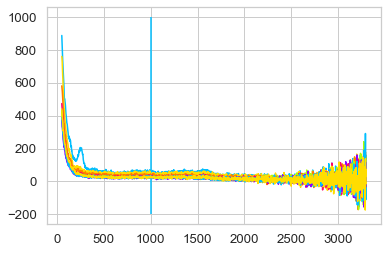

In [26]:
wavelength_cut = 1000

filenames = [
    "data/0ppm_2.mapx",
    "data/0.025ppm_2.mapx",
    "data/0.05ppm_2.mapx",
    "data/0.1ppm_2.mapx",
    "data/0.25ppm_2.mapx",
    "data/0.5ppm_2.mapx",
    "data/0.75ppm_2.mapx",
    "data/1ppm_2.mapx",
    ]

dat_class = RamanExperimentData(filenames=filenames)
spectra, w, mapsize = dat_class.maps[filenames[0]]
#spectra, w, mapsize = dat_class.read_mapx("1ppm_1.mapx")

print(spectra.shape)
print(w.shape)
print(mapsize)

for i in np.arange(0, spectra.shape[0], 500):
    plt.plot(w, spectra[i, 0:])
plt.vlines(x=1000,ymin=-200,ymax = 1000)
# We disregard all data to the right of the vertical line

We will train on the data to the left and validate on the right side

In [27]:
full_dataset = []
#validation_dataset = []

print("cutoff just before:",wavelength_cut)
# Cutoff index
idx = np.argmin(np.abs(w-wavelength_cut))
w_cut = w[:idx]

for i in range(len(filenames)):

    dat_class = RamanExperimentData(filenames=filenames)
    spectra, w, mapsize = dat_class.maps[filenames[i]]
    #spectra = spectra.reshape(*mapsize, -1)
    x = torch.from_numpy(spectra).float()
    x = x[:,:idx]
    
    full_dataset.append(x)


full_dataset = torch.cat([s for s in full_dataset])
full_dataset = full_dataset.unsqueeze(2)

#train_dataset,validation_dataset = train_test_split(full_dataset,test_size=0.25, random_state=42)
train_dataset,validation_dataset = train_test_split(full_dataset,test_size=0.15, random_state=42)
print("train shape:",train_dataset.shape)
print("validation shape:",validation_dataset.shape)

cutoff just before: 1000
train shape: torch.Size([23638, 492, 1])
validation shape: torch.Size([4172, 492, 1])


# NS model

## Encoder/decoder

In [9]:
class Encoder_NS(nn.Module):
    def __init__(self, seq_len, n_features, hidden_dim=50, num_layers=1, bidirectional=True,
                 latent_z:int=1, z_layers:int=1, latent_c:int=1):
        super(Encoder_NS, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(
            input_size=self.n_features,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=self.bidirectional
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = x.reshape((-1, self.seq_len, self.n_features))

        #(batch, hidden)
        x, (hidden_n, _) = self.lstm(x)

        if self.bidirectional:
            hidden_n = torch.cat([hidden_n[-1,:, :], hidden_n[-2,:,:]], dim=1).unsqueeze(0)
        else:
            hidden_n = hidden_n[-1, :, :]

        hidden_n = hidden_n.reshape(batch_size, -1)
        #print(hidden_n.shape)
        return hidden_n
class Decoder_NS(nn.Module):
    def __init__(self, latent_z:int, z_layers:int, latent_c:int,
                 seq_len, n_features=1, hidden_dim=50, num_layers=1, bidirectional=True):
        super(Decoder_NS, self).__init__()

        self.seq_len = seq_len
        self.hidden_dim, self.n_features = hidden_dim, n_features
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.latent_z = latent_z
        self.z_layers = z_layers
        self.latent_c = latent_c
        
        self.lstm_depth = self.num_layers + self.num_layers * int(self.bidirectional)
        
        self.latent_to_hidden = nn.Linear(self.latent_c+self.latent_z*self.z_layers,
                                          self.hidden_dim)
        
        self.hidden_to_mu = nn.Linear(self.hidden_dim + int(self.bidirectional) * self.hidden_dim, self.n_features)
        self.hidden_to_sig = nn.Linear(self.hidden_dim + int(self.bidirectional) * self.hidden_dim, self.n_features)
        
        if torch.cuda.is_available():
            self.decoder_inputs = torch.zeros(self.seq_len, self.n_features, requires_grad=True).type(torch.cuda.FloatTensor)
            self.c_0 = torch.zeros(self.lstm_depth, self.hidden_dim, requires_grad=True).type(torch.cuda.FloatTensor)
        else:
            self.decoder_inputs = torch.zeros(self.seq_len, self.n_features, requires_grad=True).type(torch.FloatTensor)
            self.c_0 = torch.zeros(self.lstm_depth, self.hidden_dim, requires_grad=True).type(torch.FloatTensor)
        
        self.lstm = nn.LSTM(
            input_size=self.n_features,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=self.bidirectional
        )
        
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        # https://github.com/hellojinwoo/TorchCoder/blob/master/autoencoders/rae.py
        # THIS LAYER CAN BE EXCLUDED
        batch_size = x.size(0)
        h_state = self.latent_to_hidden(x)        
        
        h_0 = torch.stack([h_state for _ in range(self.lstm_depth)])
        #print(f"h_0: {h_0.shape}")
        inputs = torch.stack([self.decoder_inputs for _ in range(batch_size)])
        #print(f"inputs: {inputs.shape}")
        c_inp = torch.stack([self.c_0 for _ in range(batch_size)]).permute(1,0,2).contiguous()
        #print(f"c_inp: {c_inp.shape}")
        
        decoder_output, _ = self.lstm(inputs, (h_0, c_inp))
        #print(f"DECOER OUTPUT: {decoder_output.shape}")        
        
        out_mu = self.hidden_to_mu(decoder_output).squeeze(-1)
        out_sig = self.hidden_to_sig(decoder_output).squeeze(-1)
        
        out = torch.cat([out_mu, out_sig], axis=1)
        #print(out.shape)
        
        return out

## Save function

In [10]:
def save_model(model,dir):
    state_dict = {
      "model": model.state_dict,
      "model_params": {
          "latent_c": model.latent_c,
          "latent_z": model.latent_z,
          "z_layers": model.z_layers,
          "n_features": model.n_features,
          "beta1": model.beta1,
          "beta2": model.beta2,
          "seq_len": model.seq_len,
          "hidden_dim": model.hidden_dim,
          "num_layers": model.num_layers,
          "bidirectional": model.bidirectional
      },
      "LEARNING_RATE": optimizer.param_groups[0]['lr'],
      "encoder_decoder_params": {
          "seq_len": model.seq_len,
          "n_features": model.n_features,
          "hidden_dim": model.hidden_dim,
          "latent_c": model.latent_c,
          "latent_z": model.latent_z,
          "z_layers": model.z_layers,
          "num_layers": model.num_layers,
          "bidirectional": model.bidirectional,
      },
      "optimizer": optimizer.state_dict(),
      "epoch": epoch,
      "training_info": training_info,
      "validation_info": validation_info
    }
    torch.save(state_dict,dir)

## Initialize model

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#LATENT_C = 3
LATENT_C = 5
LATENT_Z = 3
#Z_LAYERS = 3
Z_LAYERS = 5


N_FEATURES = 1
HIDDEN_DIM = 100
#NUM_LAYERS = 2
NUM_LAYERS = 3
BATCH_SIZE = 256
LEARNING_RATE = 5e-4
bidirectional = True
seq_len = idx
BETA1 = 0.01
BETA2 = 0.01

encoder = Encoder_NS(seq_len=seq_len, n_features=N_FEATURES, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, bidirectional=bidirectional).to(device)
decoder = Decoder_NS(seq_len=seq_len, latent_z = LATENT_Z,z_layers = Z_LAYERS, latent_c = LATENT_C,
                n_features=N_FEATURES, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, bidirectional=bidirectional).to(device)
model = Neural_Stat(Encoder = encoder, Decoder=decoder,
                    seq_len=seq_len, latent_z = LATENT_Z,z_layers = Z_LAYERS, latent_c = LATENT_C,
                n_features=N_FEATURES, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, bidirectional=bidirectional,
                beta1=BETA1,beta2=BETA2).to(device)
print(model.bidirectional)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from collections import defaultdict
training_info = defaultdict(list)
validation_info = defaultdict(list)

epoch = 0

True


### Data Loader

In [15]:
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

#FOR NOW VALIDATION IS SAME AS TRAINING...
validation_loader = DataLoader(validation_dataset, batch_size=45*77, shuffle=True)

### Load model

In [12]:
#checkpoint = torch.load('/content/drive/MyDrive/Advanced_ML/NS_data.pkl',map_location = "cpu")
checkpoint = torch.load('/content/drive/MyDrive/Advanced_ML/NS_data_new.pkl')

In [13]:
from collections import defaultdict
# Getting training info
training_info = checkpoint['training_info']
validation_info = checkpoint['validation_info']
epoch = checkpoint['epoch']
# Reloading the model
encoder = Encoder_NS(**checkpoint['encoder_decoder_params']).to(device)
decoder = Decoder_NS(**checkpoint['encoder_decoder_params']).to(device)
model = Neural_Stat(Encoder=encoder, Decoder=decoder, **checkpoint["model_params"]).to(device)
model.load_state_dict(checkpoint["model"]())
# Reloading the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=checkpoint['LEARNING_RATE'])
optimizer.load_state_dict(checkpoint["optimizer"])
print(epoch)

290


In [19]:
model.latent_c

5

## Training loop

In [ ]:
NUM_EPOCHS = 500
while epoch <= NUM_EPOCHS:  
    # Running training data
    training_epoch_info = defaultdict(list)
    model.train()

    model.beta1 = 10 * epoch / NUM_EPOCHS
    model.beta2 = 10 * epoch / NUM_EPOCHS

    for batch in train_loader:
        batch = batch.to(device)
        loss, diagnostics, outputs = model.elbo(batch)
 
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_info[k] += [v.mean().item()]

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=10)
        optimizer.step()
        
    # gather data for the full epoch
    for k, v in training_epoch_info.items():
        training_info[k] += [np.mean(training_epoch_info[k])]
    
    # Validation set
    with torch.no_grad():
        model.eval()        
        # Just load a single batch from the test loader
        x = next(iter(validation_loader))
        x = x.to(device)
        val_loss, diagnostics, _ = model.elbo(x)
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_info[k] += [v.mean().item()]
            
    epoch += 1

    if epoch % 1 == 0:
        print(f"epoch {epoch}")
        print(f"Average ELBO: {np.mean(training_info['elbo'][-25:])}")
        print(f"Validation ELBO: {np.mean(validation_info['elbo'][-25:])}")
    # Safety break
    if np.isnan(loss.detach().cpu().numpy()):
        break

    if epoch!= 0:      
        if epoch % 10 == 0:
            dir = '/content/drive/MyDrive/Advanced_ML/NS_data_new.pkl'
            save_model(model,dir)
    if epoch % 100 == 0:
        dir = f'/content/drive/MyDrive/Advanced_ML/baseline_data_new_{epoch}.pkl'
        save_baseline_model(model,dir)
    
    


epoch 1
Average ELBO: -73197.99813350555
Validation ELBO: -12257.4912109375
epoch 2
Average ELBO: -37903.6009718372
Validation ELBO: -7220.7724609375
epoch 3
Average ELBO: -25986.345217906448
Validation ELBO: -5496.064534505208
epoch 4
Average ELBO: -19997.568348546185
Validation ELBO: -4612.856750488281
epoch 5
Average ELBO: -16396.324142882648
Validation ELBO: -4081.4206787109374
epoch 6
Average ELBO: -13990.401656174747
Validation ELBO: -3721.1583251953125
epoch 7
Average ELBO: -12267.325490268879
Validation ELBO: -3458.178449358259
epoch 8
Average ELBO: -10965.21652992823
Validation ELBO: -3250.4681854248047
epoch 9
Average ELBO: -9948.89248347311
Validation ELBO: -3086.324123806424
epoch 10
Average ELBO: -9130.229035802044
Validation ELBO: -2950.86220703125
epoch 11
Average ELBO: -8459.819528529373
Validation ELBO: -2836.4614479758525
epoch 12
Average ELBO: -7898.149945987169
Validation ELBO: -2736.0841674804688
epoch 13
Average ELBO: -7418.532479386374
Validation ELBO: -2648.6200

In [19]:
#outputs = model.forward(batch)
#outputs.keys()
outputs['px'].mu.min()

tensor(nan, device='cuda:0', grad_fn=<MinBackward1>)

# Testing

In [ ]:
model.to(device)


dict_keys(['px', 'posterior_z_L', 'posterior_z_i', 'prior_z_L', 'z_L', 'prior_z_i', 'z_i', 'posterior_c', 'prior_c', 'c', 'z'])

In [ ]:
validation_dataset[:2,:2,:]

tensor([[[161.1262],
         [156.2286]],

        [[265.9463],
         [261.5811]]])

In [ ]:
idx = np.random.choice(range(validation_dataset.shape[0]),size=16).tolist()
i=0
validation_dataset[idx[i],:,:].reshape(1,-1,1).shape

torch.Size([1, 492, 1])

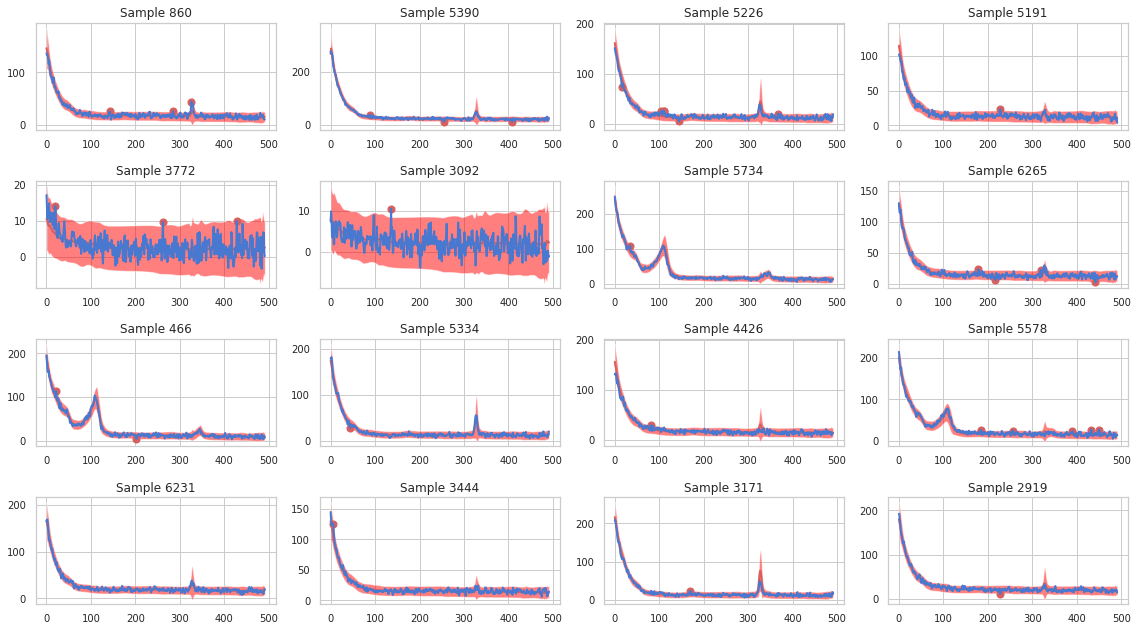

In [ ]:
plot_sequences(model, PLOT_DATA=validation_dataset,NUM_PLOTS=16,samples=idx,ANOMALY_THRESHOLD=1/500)

In [ ]:
from utils import total_reconstruction_err

In [ ]:
total_reconstruction_err(model=model,dataset=validation_dataset[:500,:,:])

# Voigt profile

In [6]:
spectra, w, mapsize = dat_class.maps[filenames[1]]

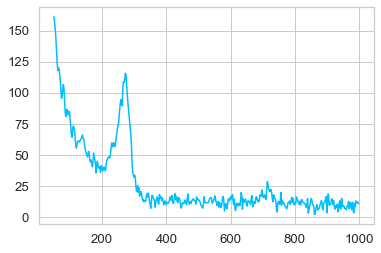

In [7]:
plt.plot(w_cut,validation_dataset[0,:,0])

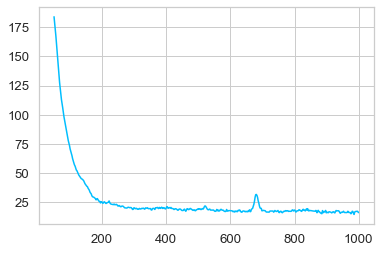

In [8]:
#for i in range(100):
#    plt.plot(w[w<1000],spectra[i,w<1000])
plt.plot(w[w<1000],np.mean(spectra[:,w<1000],axis=0))

sum of distribution: 0.9968168480841275


Text(0.5, 1.0, 'Testing voigt profile')

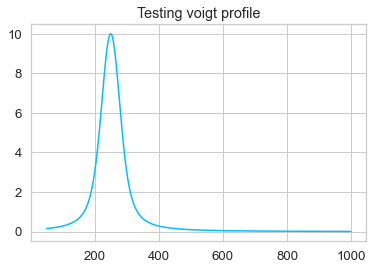

In [9]:
import scipy
import scipy.integrate as integrate
print("sum of distribution:",integrate.quad(lambda x: scipy.special.voigt_profile(x,0.5,0.5),-100,100)[0])

def voigt(x,mu,sigma,gamma,z):
    y = scipy.special.voigt_profile(x-mu,sigma,gamma)
    y = z*y/np.max(y)
    return y
w_cut = w[w<1000]
plt.plot(w_cut,voigt(w_cut,250,20,20,10))
plt.title("Testing voigt profile")


In [18]:
spectra, w, mapsize = dat_class.maps[filenames[7]]
w_cut = w[w<1000]

In [367]:
dat = spectra[1768,w<=1000]
dat.shape
max_val = np.max(dat)
max_val

507.15646

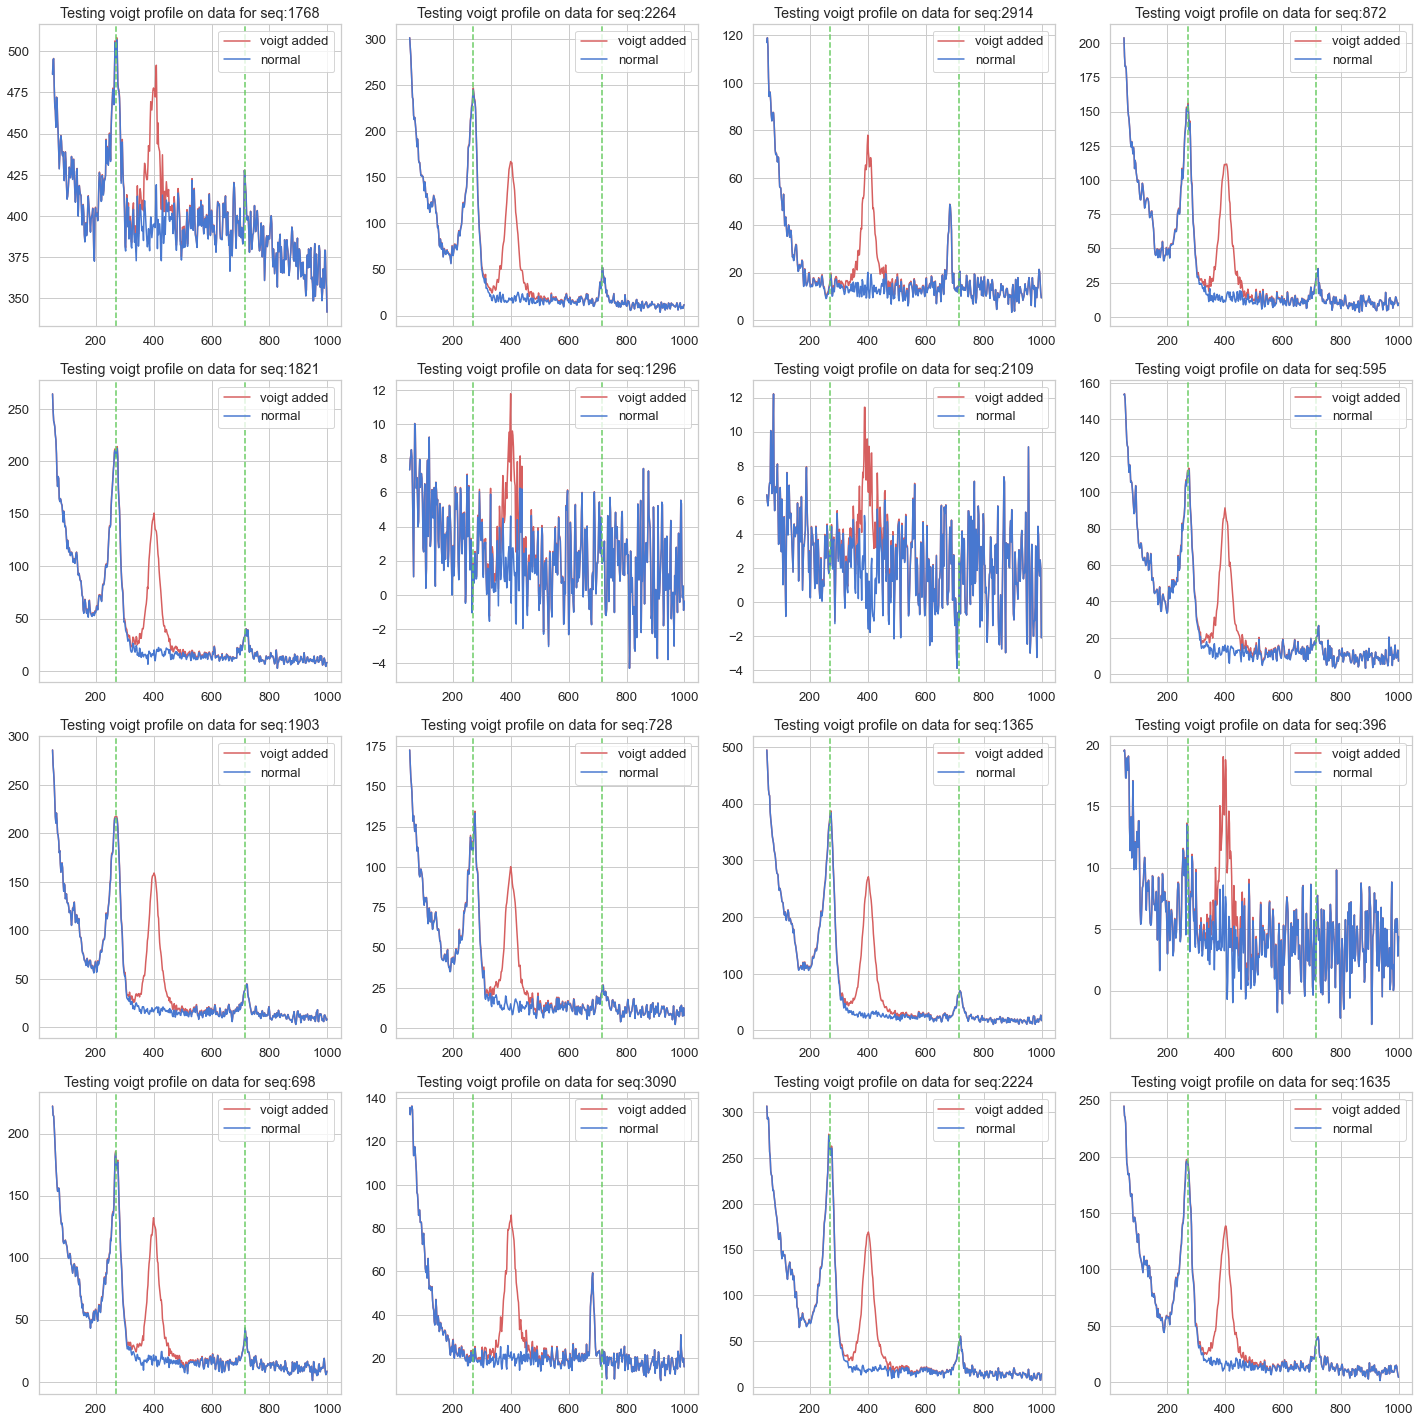

In [369]:
i = np.random.choice(spectra.shape[0],size=16)
i[0]=1768
#i = np.arange(16)
fig,axes = plt.subplots(4,4,figsize=(20,20))
for k,ax in enumerate(axes.flat):
    dat = spectra[i[k],w<=1000]
    max_val = np.max(dat)-np.min(dat)
    
    ax.plot(w[w<1001],dat+voigt(w[w<1001],400,12,12,max_val*0.5),label="voigt added",c = 'r')
    ax.plot(w[w<1001],dat,label="normal",c='b')
    ax.legend()
    ax.axvline(x=270,color='g', linestyle='--')
    ax.axvline(x=715,color='g', linestyle='--')
    ax.set_title("Testing voigt profile on data for seq:{}".format(i[k]))
fig.tight_layout()
#fig.show()

289.26923


Text(0.5, 1.0, 'Testing voigt profile on data for seq:[ 747 2904  474 1082 2558 2047 2747  975 1806  189 3005 2734 3005  562\n 1899 1267]')

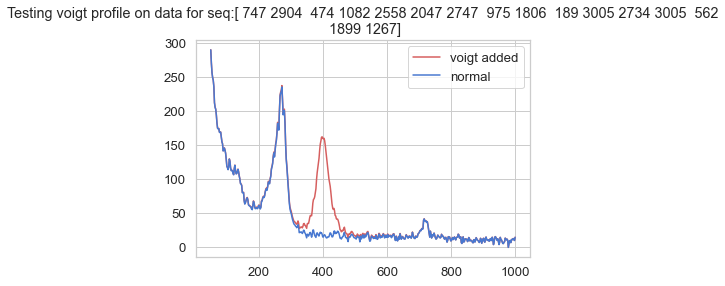

In [20]:

print(max_val)
plt.plot(w_cut,dat+voigt(w_cut,400,12,12,max_val*0.5),label="voigt added",c = 'r')
plt.plot(w_cut,dat,label="normal",c='b')
plt.legend()
plt.title("Testing voigt profile on data for seq:{}".format(i))

In [23]:
spectra[0,w<1000].reshape(-1).shape

(493,)

In [24]:
w_cut.shape

(493,)

In [144]:
validation_dataset_np = validation_dataset.numpy()
max_val= np.zeros(validation_dataset.shape[0])
min_val= np.zeros(validation_dataset.shape[0])
peak1 = np.zeros(validation_dataset.shape[0])
peak2 = np.zeros(validation_dataset.shape[0])
for i in range(validation_dataset.shape[0]):
    max_val[i] = np.max(validation_dataset_np[i,:,0])
    min_val[i] = np.min(validation_dataset_np[i,:,0])
    idx1 = (w_cut>200)&(w_cut<400)
    idx2 = (w_cut>400)
    peak1[i] = np.max(validation_dataset_np[i,idx1,0])
    peak2[i] = np.max(validation_dataset_np[i,idx2,0])
print(np.argmax(validation_dataset_np[i,idx1,0]))
print(np.argmax(validation_dataset_np[i,idx2,0]))


19
71


In [ ]:
(peak2-min_val)/(max_val-min_val)

array([0.17544349, 0.14113765, 0.2352726 , ..., 0.19646398, 0.1469101 ,
       0.20241392])

In [29]:
np.histogram((peak1-min_val)/(max_val-min_val))

(array([1928,  771,  238,  221,  221,  117,  139,  327,  186,   24],
       dtype=int64),
 array([0.0406092 , 0.13654828, 0.23248736, 0.32842644, 0.42436552,
        0.5203046 , 0.61624368, 0.71218276, 0.80812184, 0.90406092,
        1.        ]))

(array([3359.,  864.,  306.,  299.,  318.,  146.,   85.,  216.,  362.,
          83.]),
 array([0.08648156, 0.17026179, 0.25404202, 0.33782224, 0.42160247,
        0.5053827 , 0.58916292, 0.67294315, 0.75672338, 0.8405036 ,
        0.92428383]),
 <a list of 10 Patch objects>)

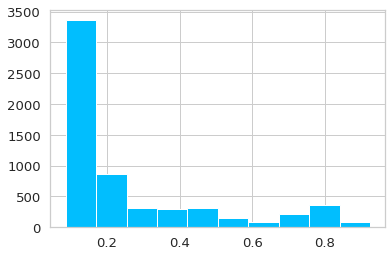

In [ ]:
plt.hist(peak1[max_val>100]/max_val[max_val>100])

(array([ 975., 1824., 1547.,  563.,  407.,  289.,  177.,  185.,   60.,
          11.]),
 array([0.069285  , 0.11684456, 0.16440411, 0.21196367, 0.25952322,
        0.30708278, 0.35464233, 0.40220189, 0.44976144, 0.497321  ,
        0.54488055]),
 <a list of 10 Patch objects>)

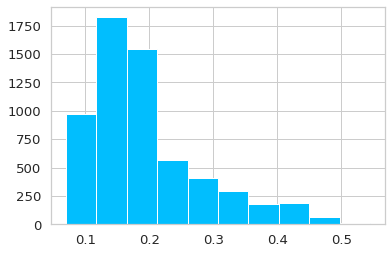

In [ ]:
plt.hist(peak2[max_val>100]/max_val[max_val>100])

<ipython-input-125-94b18f1c997b>:4: RuntimeWarning: invalid value encountered in power
  ax.flat[0].plot(np.arange(1,1200),-0.01+1/((np.arange(1,1200)-10)**0.4),c="r",linewidth=2,label=r"$1/x^{0.4}$")
<ipython-input-125-94b18f1c997b>:4: RuntimeWarning: divide by zero encountered in true_divide
  ax.flat[0].plot(np.arange(1,1200),-0.01+1/((np.arange(1,1200)-10)**0.4),c="r",linewidth=2,label=r"$1/x^{0.4}$")
<ipython-input-125-94b18f1c997b>:15: RuntimeWarning: invalid value encountered in power
  ax.flat[1].plot(np.arange(1,1200),-0.04+1/((np.arange(1,1200)-10)**0.4),c='r',label=r"$1/x^{0.4}$")
<ipython-input-125-94b18f1c997b>:15: RuntimeWarning: divide by zero encountered in true_divide
  ax.flat[1].plot(np.arange(1,1200),-0.04+1/((np.arange(1,1200)-10)**0.4),c='r',label=r"$1/x^{0.4}$")


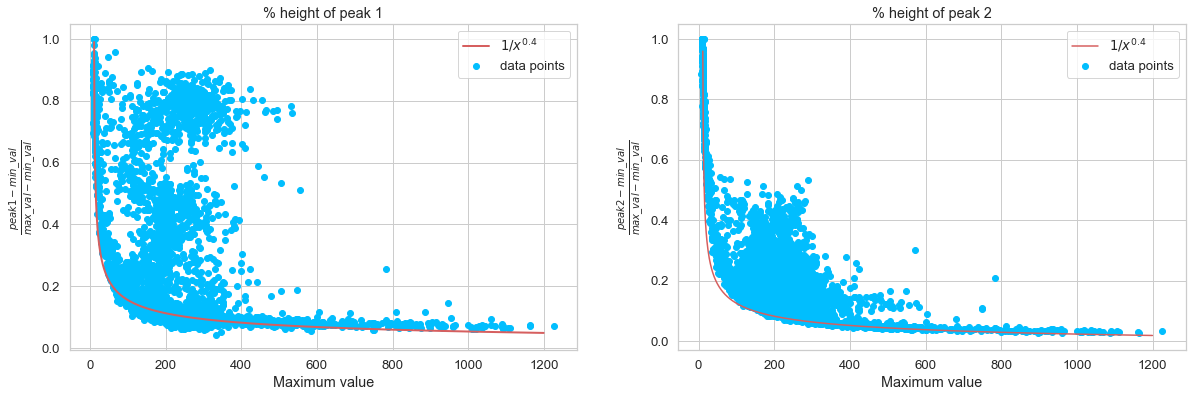

In [125]:
fig, ax = plt.subplots(1,2,figsize=(20,6))

ax.flat[0].scatter(max_val,(peak1-min_val)/(max_val-min_val),label="data points")
ax.flat[0].plot(np.arange(1,1200),-0.01+1/((np.arange(1,1200)-10)**0.4),c="r",linewidth=2,label=r"$1/x^{0.4}$")
#ax.flat[0].plot(np.arange(1,1200),1/((np.arange(1,1200)-10)**0.425),c="g",linewidth=2,label=r"$1/x^{0.425}$")
#ax.flat[0].plot(np.arange(1,1200),1/((np.arange(1,1200)-10)**0.45),c="y",linewidth=2,label=r"$1/x^{0.45}$")
#ax.flat[0].plot(np.arange(1,1200),1/((np.arange(1,1200)-10)**0.5),c="m",linewidth=2,label=r"$1/x^{0.5}$")
ax.flat[0].set_xlabel("Maximum value")
ax.flat[0].set_ylabel(r"$\frac{peak1-min\_val}{max\_val-min\_val}$")
ax.flat[0].set_title("% height of peak 1")
ax.flat[0].legend()

ax.flat[1].scatter(max_val,(peak2-min_val)/(max_val-min_val),label="data points")
#ax.flat[1].plot(np.arange(1,1200),-0.07+1/((np.arange(1,1200)-10)**0.35),c='m',label=r"$1/x^{0.35}$")
ax.flat[1].plot(np.arange(1,1200),-0.04+1/((np.arange(1,1200)-10)**0.4),c='r',label=r"$1/x^{0.4}$")
#ax.flat[1].plot(np.arange(1,1200),-0.05+1/((np.arange(1,1200)-10)**0.43),c='g',label=r"$1/x^{0.43}$")
#ax.flat[1].plot(np.arange(1,1200),-0.05+1/((np.arange(1,1200)-10)**0.45),c='y',label=r"$1/x^{0.45}$")
ax.flat[1].set_xlabel("Maximum value")
ax.flat[1].set_ylabel(r"$\frac{peak2-min\_val}{max\_val-min\_val}$")
ax.flat[1].set_title("% height of peak 2")
ax.flat[1].legend()



Text(0.5, 0, 'max_val')

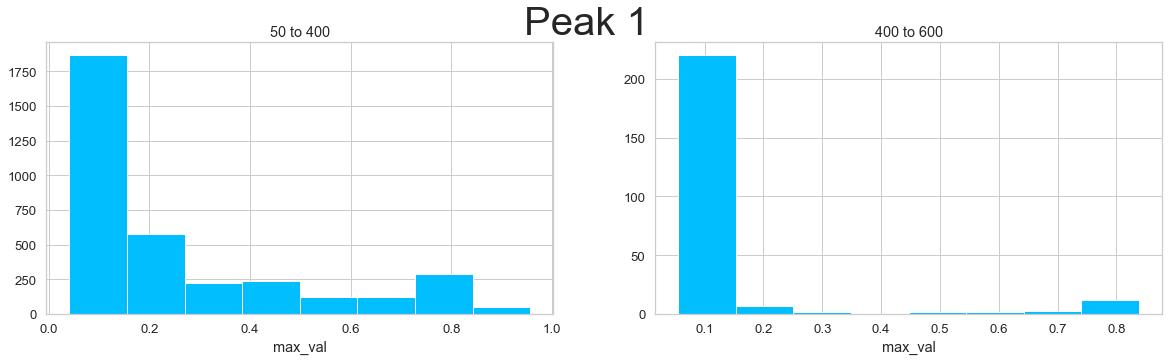

In [141]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
fig.suptitle("Peak 1",size=40)
low = 50
max = 400
ax.flat[0].hist((peak1[(max_val>low)&(max_val<max)]-min_val[(max_val>low)&(max_val<max)])/(max_val[(max_val>low)&(max_val<max)]-min_val[(max_val>low)&(max_val<max)]),bins=8)
ax.flat[0].set_title(f"{low} to {max}")
ax.flat[0].set_xlabel("max_val")
low = 400
max = 600
ax.flat[1].hist((peak1[(max_val>low)&(max_val<max)]-min_val[(max_val>low)&(max_val<max)])/(max_val[(max_val>low)&(max_val<max)]-min_val[(max_val>low)&(max_val<max)]),bins=8)
ax.flat[1].set_title(f"{low} to {max}")
ax.flat[1].set_xlabel("max_val")

Text(0.5, 0, 'max_val')

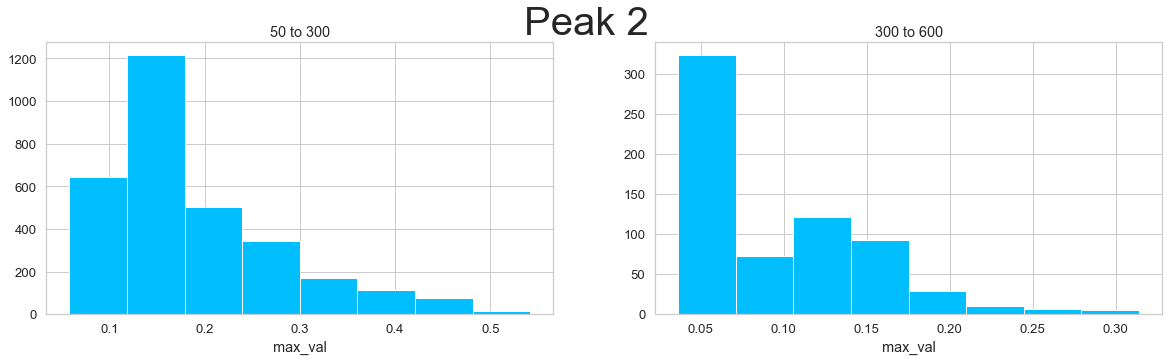

In [140]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
fig.suptitle("Peak 2",size=40)
low = 50
max = 300
ax.flat[0].hist((peak2[(max_val>low)&(max_val<max)]-min_val[(max_val>low)&(max_val<max)])/(max_val[(max_val>low)&(max_val<max)]-min_val[(max_val>low)&(max_val<max)]),bins=8)
ax.flat[0].set_title(f"{low} to {max}")
ax.flat[0].set_xlabel("max_val")
low = 300
max = 600
ax.flat[1].hist((peak2[(max_val>low)&(max_val<max)]-min_val[(max_val>low)&(max_val<max)])/(max_val[(max_val>low)&(max_val<max)]-min_val[(max_val>low)&(max_val<max)]),bins=8)
ax.flat[1].set_title(f"{low} to {max}")
ax.flat[1].set_xlabel("max_val")

In [ ]:
i = np.random.choice(spectra.shape[0],size=16)
#i = np.arange(16)
min_height = 0.2
fig,axes = plt.subplots(4,4,figsize=(20,20))
for k,ax in enumerate(axes.flat):
    dat = spectra[i[k],w<=1000]
    max_val = np.max(dat)
    min_val = np.min(dat)
    mu = np.random.choice(np.arange(100,900),size=1)
    
    if mu<600:
        max_height = min_height
    elif mu < 360+mu*(400-300)/(715-270)
    
    ax.plot(w_cut,dat+voigt(w_cut,400,12,12,max_val*0.5),label="voigt added",c = 'r')
    ax.plot(w_cut,dat,label="normal",c='b')
    ax.legend()
    ax.set_title("Testing voigt profile on data for seq:{}".format(i[k]))
fig.tight_layout()

In [363]:
min_uniform = 0.15
mu = np.random.choice(np.arange(100,900),size=1)
#mu = 
print("mu = ",mu)
if mu>800:
    max_uniform = min_uniform
elif mu < (360+mu*(400-300)/(715-270)):
    max_uniform = 1+mu * (0.5-0.85)/(715-270)
else:
    max_uniform = 1.1+mu * (0.3-0.8)/(715-270)
print(max_uniform)
print(np.random.uniform(low=min_uniform,high=max_uniform,size=1))

mu =  [860]
0.15
[0.15]


In [342]:
0.8-270*(0.3-0.8)/(715-270)

1.103370786516854

In [195]:
(400-300)/(715-270)

0.2247191011235955

In [197]:
300+270*(400-300)/(715-270)

360.6741573033708